# Unsupervised Learning: The Ice Cream Fleet Expansion

Welcome back, **Ice Cream Mogul**.

In the last lab, we used **Supervised Learning** to predict sales ($y$) based on temperature ($x$). We had historic data where we knew the answer.

**The New Problem**: Your business is booming. You want to deploy a fleet of **Ice Cream Trucks** to serve the city efficiently.

**The Data**: You have the GPS coordinates of 300 customers who tweeted "I want ice cream!"

**The Catch**: You don't know which "neighborhood" usually belongs together. You just have dots on a map.

**Your Goal**: Group these customers into clusters so you can park a truck in the center of each group.

---


In [1]:
# --- PROFESSOR'S TOOLS ---
# Initialize the lab environment

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider, Checkbox, Button, Output, VBox, HBox, Label
import ipywidgets as widgets
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
import time

# Aesthetic Setup
plt.style.use('seaborn-v0_8-darkgrid')
COLORS = ['#E74C3C', '#3498DB', '#F1C40F', '#2ECC71', '#9B59B6', '#34495E'] # Red, Blue, Yellow, Green, Purple, Navy
CUSTOMER_COLOR = '#BDC3C7' # Grey

print("✅ Lab Environment Initialized.")

✅ Lab Environment Initialized.


## Part 1: The Intuition (Manual Clustering)

Before asking the machine to do it, let's try it ourselves.

Below are the locations of your potential customers. 
You have **3 Trucks**. Where should you park them to minimize the walking distance for customers?

### Interactive Challenge
1.  **Look** at the grey dots (Customers).
2.  **Adjust** the sliders to move the Red, Blue, and Yellow trucks ($x, y$ coordinates).
3.  Notice how the customers change color based on which truck is closest.

In [2]:
# 1. Generate Customer Data (Simulation)
np.random.seed(42)
X, _ = make_blobs(n_samples=300, centers=3, cluster_std=1.5, random_state=101)

def plot_manual_cluster(ax1, ay1, ax2, ay2, ax3, ay3):
    centroids = np.array([[ax1, ay1], [ax2, ay2], [ax3, ay3]])
    
    # Calculate distances: Who is closest to which truck?
    # Just for visualization logic (don't worry about code yet)
    distances = np.linalg.norm(X[:, np.newaxis] - centroids, axis=2)
    closest_centroid = np.argmin(distances, axis=1)
    
    # Plot
    plt.figure(figsize=(10, 8))
    
    # Plot Customers, colored by their nearest truck
    for i in range(3):
        cluster_points = X[closest_centroid == i]
        plt.scatter(cluster_points[:, 0], cluster_points[:, 1], c=COLORS[i], alpha=0.3, s=30, label=f'Territory {i+1}')
    
    # Plot Trucks (Centroids)
    plt.scatter(centroids[:, 0], centroids[:, 1], c=COLORS[:3], s=300, edgecolor='black', marker='*', linewidth=2, label='Trucks')
        
    plt.title('Ice Cream Territories (Voronoi Regions)', fontsize=16)
    plt.xlabel('City West-East (KM)')
    plt.ylabel('City South-North (KM)')
    plt.legend()
    plt.grid(True)
    plt.show()

interact(plot_manual_cluster, 
         ax1=IntSlider(min=-12, max=5, value=-10, description='Truck 1 X'), ay1=IntSlider(min=-10, max=10, value=-5, description='Truck 1 Y'),
         ax2=IntSlider(min=-12, max=5, value=-5, description='Truck 2 X'), ay2=IntSlider(min=-10, max=10, value=8, description='Truck 2 Y'),
         ax3=IntSlider(min=-12, max=5, value=0, description='Truck 3 X'), ay3=IntSlider(min=-10, max=10, value=0, description='Truck 3 Y'));

interactive(children=(IntSlider(value=-10, description='Truck 1 X', max=5, min=-12), IntSlider(value=-5, descr…

## Part 2: The Algorithm (K-Means from Scratch)

Visual inspection is easy with 3 dots. But what if you have 50 trucks in 20 cities?

We need an **Algorithm** that automates what your brain just did. 
It's called **K-Means**, and it only has two steps:

1.  **Assign**: Every customer joins the team of the nearest Truck.
2.  **Update**: Each Truck drives to the exact *center (mean)* of its current team.
3.  *Repeat* until the trucks stop moving.

### Interactive Animation
Click the buttons below to step through the algorithm manually.

In [ ]:
# Code the Algorithm from scratch for educational purposes

class VisualKMeans:
    def __init__(self, X, k=3):
        self.X = X
        self.k = k
        # Start with random centroids
        idx = np.random.choice(len(X), k, replace=False)
        self.centroids = X[idx]
        self.labels = np.zeros(len(X))
        self.iteration = 0
        
    def step_assign(self):
        # 1. Calculate distance from each point to each centroid
        distances = np.linalg.norm(self.X[:, np.newaxis] - self.centroids, axis=2)
        # 2. Assign label based on minimum distance
        self.labels = np.argmin(distances, axis=1)
        return "Assigned Customers to Nearest Truck"
    
    def step_update(self):
        diff = 0
        for i in range(self.k):
            # Find all points belonging to this cluster
            points = self.X[self.labels == i]
            if len(points) > 0:
                new_center = points.mean(axis=0)
                diff += np.linalg.norm(self.centroids[i] - new_center)
                self.centroids[i] = new_center
        self.iteration += 1
        return f"Moved Trucks to Center of Customers (Movement: {diff:.2f})"

    def plot(self, title_extra=""):
        plt.figure(figsize=(8, 6))
        plt.scatter(self.X[:, 0], self.X[:, 1], c=[COLORS[int(l)] for l in self.labels], alpha=0.4, s=30)
        plt.scatter(self.centroids[:, 0], self.centroids[:, 1], c=COLORS[:self.k], s=200, marker='*', edgecolor='black', linewidth=2)
        plt.title(f'K-Means Iteration {self.iteration}: {title_extra}')
        plt.show()

# Create the Interactive Object
v_kmeans = VisualKMeans(X, k=3)

# UI Buttons
btn_assign = Button(description="Step 1: Assign Customers")
btn_update = Button(description="Step 2: Move Trucks")
btn_reset = Button(description="Reset Simulation")
out_viz = Output()

def on_assign(_):
    msg = v_kmeans.step_assign()
    with out_viz:
        out_viz.clear_output(wait=True)
        v_kmeans.plot(msg)

def on_update(_):
    msg = v_kmeans.step_update()
    with out_viz:
        out_viz.clear_output(wait=True)
        v_kmeans.plot(msg)
        
def on_reset(_):
    global v_kmeans
    v_kmeans = VisualKMeans(X, k=3)
    with out_viz:
        out_viz.clear_output(wait=True)
        print("Simulation Reset. Click 'Assign' to start.")
        v_kmeans.plot("Start")

btn_assign.on_click(on_assign)
btn_update.on_click(on_update)
btn_reset.on_click(on_reset)

display(HBox([btn_assign, btn_update, btn_reset]))
display(out_viz)

with out_viz:
    v_kmeans.plot("Start")

Output()

## Part 3: The Elbow Method (How many trucks?)

We guessed $K=3$. But why not 5? Or 10?

-   **More Trucks** = Less walking for customers (Better Service).
-   **More Trucks** = Higher maintenance cost (More Expensive).

The **Inertia** is the total distance all customers have to walk.
We plot **Inertia vs. K**. As we add trucks, inertia drops rapidly, then levels off. That "Elbow" point is the optimal balance.

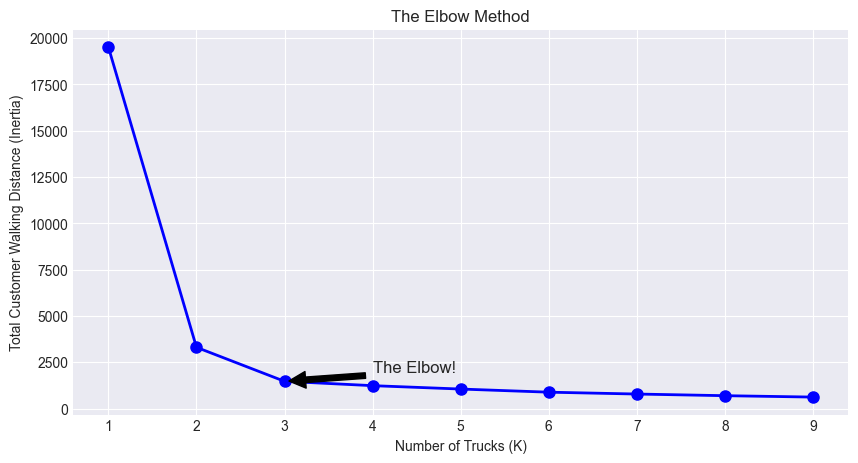

In [4]:
# Calculating Inertia for different K values
inertias = []
k_range = range(1, 10)

for k in k_range:
    model = KMeans(n_clusters=k, random_state=42, n_init=10)
    model.fit(X)
    inertias.append(model.inertia_)

plt.figure(figsize=(10, 5))
plt.plot(k_range, inertias, 'bo-', linewidth=2, markersize=8)
plt.xlabel('Number of Trucks (K)')
plt.ylabel('Total Customer Walking Distance (Inertia)')
plt.title('The Elbow Method')
plt.annotate('The Elbow!', xy=(3, inertias[2]), xytext=(4, inertias[2]+500), 
             arrowprops=dict(facecolor='black', shrink=0.05), fontsize=12)
plt.show()

## Bonus: Color Compression (Real World Art)

Clustering isn't just for maps. It works on **Colors** too.
Digital images have millions of colors. We can use K-Means to find the "Dominant Strategy" of a painting.

Below, we generate a synthetic "Modern Art" image and compress it to just its top 3 colors.

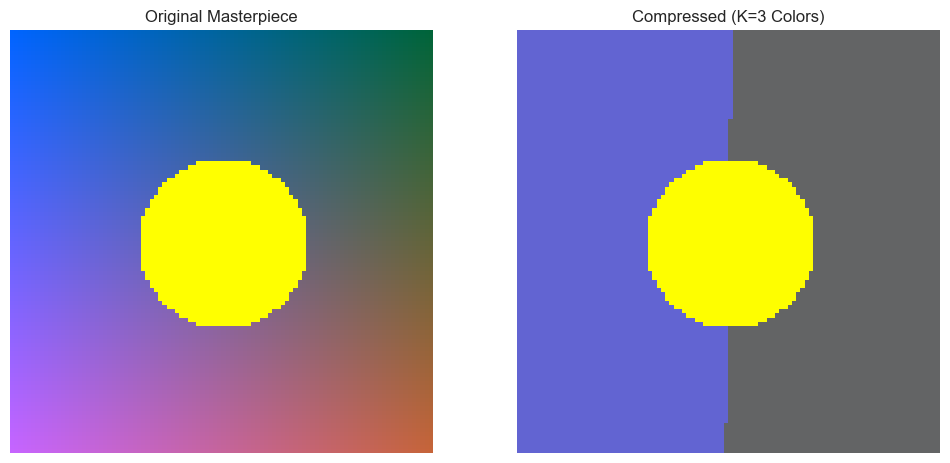

The 3 Dominant Colors (RGB) are:
[[ 98 100 210]
 [254 254   0]
 [ 99 100 101]]


In [7]:
# 1. Create a Synthetic Image (Gradient + Shapes)
height, width = 100, 100
image = np.zeros((height, width, 3), dtype=np.uint8)

# Background Gradient
for i in range(height):
    image[i, :, 0] = i * 2  # Red gradient
    image[i, :, 1] = 100    # Green constant
    image[:, i, 2] = 255 - i*2 # Blue inverse gradient

# Add a vibrant circle
y, x = np.ogrid[:height, :width]
mask = (x - 50)**2 + (y - 50)**2 < 20**2
image[mask] = [255, 255, 0] # Yellow Circle

# Flatten the image: treated as a list of 10,000 pixels (R, G, B)
pixels = image.reshape(-1, 3)

# 2. Find the 3 Dominant Colors (K-Means)
model = KMeans(n_clusters=3, random_state=42, n_init=5)
model.fit(pixels)
dominant_colors = model.cluster_centers_.astype(int)
labels = model.predict(pixels)

# 3. Reconstruct the Compressed Image
compressed_pixels = dominant_colors[labels]
compressed_image = compressed_pixels.reshape(height, width, 3)

# Visualize
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(image)
ax[0].set_title('Original Masterpiece')
ax[0].axis('off')

ax[1].imshow(compressed_image)
ax[1].set_title('Compressed (K=3 Colors)')
ax[1].axis('off')

plt.show()

print(f"The 3 Dominant Colors (RGB) are:\n{dominant_colors}")